* Student name: Steve Newman
* Student pace: part time 
* Scheduled project review date/time: Mon. May 11 2pm EST
* Instructor name: James Irving PhD
* Blog post URL:https://medium.com/@stevenewmanphotography/classification-blog-e73e72cb8450

In [ ]:
from IPython.display import clear_output
!pip install -U fsds_100719
clear_output()
from fsds_100719.imports import *

from sklearn.model_selection import train_test_split

import sklearn.metrics as metrics
import tzlocal
import datetime as dt

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBRFClassifier,XGBClassifier

import warnings
warnings.filterwarnings('ignore')

plt.style.use('ggplot')


# Defintions

The data used in this project is from an anonymous organisation’s social media ad campaign. The data file can be downloaded from here. The file conversion_data.csv contains 1143 observations in 11 variables. Below are the descriptions of the variables.

1.) ad_id: an unique ID for each ad.

2.) xyzcampaignid: an ID associated with each ad campaign of XYZ company.

3.) fbcampaignid: an ID associated with how Facebook tracks each campaign.

4.) age: age of the person to whom the ad is shown.

5.) gender: gender of the person to whim the add is shown

6.) interest: a code specifying the category to which the person’s interest belongs (interests are as mentioned in the person’s Facebook public profile).

7.) Impressions: the number of times the ad was shown.

8.) Clicks: number of clicks on for that ad.

9.) Spent: Amount paid by company xyz to Facebook, to show that ad.

10.) Total conversion: Total number of people who enquired about the product after seeing the ad.

11.) Approved conversion: Total number of people who bought the product after seeing the ad.

# Explored Data Set

In [82]:
df = pd.read_csv('KAG_conversion_data.csv')
df

,ad_id,xyz_campaign_id,fb_campaign_id,age,gender,interest,Impressions,Clicks,Spent,Total_Conversion,Approved_Conversion
0,708746,916,103916,30-34,M,15,7350,1,1.430000,2,1
1,708749,916,103917,30-34,M,16,17861,2,1.820000,2,0
2,708771,916,103920,30-34,M,20,693,0,0.000000,1,0
3,708815,916,103928,30-34,M,28,4259,1,1.250000,1,0
4,708818,916,103928,30-34,M,28,4133,1,1.290000,1,1
...,...,...,...,...,...,...,...,...,...,...,...
1138,1314410,1178,179977,45-49,F,109,1129773,252,358.189997,13,2
1139,1314411,1178,179978,45-49,F,110,637549,120,173.880003,3,0
1140,1314412,1178,179979,45-49,F,111,151531,28,40.289999,2,0
1141,1314414,1178,179981,45-49,F,113,790253,135,198.710000,8,2


In [83]:
# No missing values.
df.isna().sum()

ad_id                  0
xyz_campaign_id        0
fb_campaign_id         0
age                    0
gender                 0
interest               0
Impressions            0
Clicks                 0
Spent                  0
Total_Conversion       0
Approved_Conversion    0
dtype: int64

In [84]:
# Will need to convert some columns to categories.
df.dtypes

ad_id                    int64
xyz_campaign_id          int64
fb_campaign_id           int64
age                     object
gender                  object
interest                 int64
Impressions              int64
Clicks                   int64
Spent                  float64
Total_Conversion         int64
Approved_Conversion      int64
dtype: object

In [85]:
# ad_id needs to be dropped due to number of unique values.
df.nunique()

ad_id                  1143
xyz_campaign_id           3
fb_campaign_id          691
age                       4
gender                    2
interest                 40
Impressions            1130
Clicks                  183
Spent                   869
Total_Conversion         32
Approved_Conversion      16
dtype: int64

# Prepare Data for Modeling

In [86]:
df= df.drop(columns=['ad_id'])

In [87]:
# Check if 'Approved_Conversion' correlates with the target.
df.corr().loc['Approved_Conversion']

xyz_campaign_id        0.284968
fb_campaign_id         0.257658
interest               0.058353
Impressions            0.684249
Clicks                 0.559526
Spent                  0.593178
Total_Conversion       0.864034
Approved_Conversion    1.000000
Name: Approved_Conversion, dtype: float64

In [88]:
# Convert 'fb_campaign_id' to value count number due to approximately 700 unique values.
campaign_id = dict(df['fb_campaign_id'].value_counts())
df['fb_counts'] = df['fb_campaign_id'].map(campaign_id)
df['fb_counts'].value_counts(dropna=False)

1    463
2    218
3    153
4    148
5    125
6     36
Name: fb_counts, dtype: int64

In [89]:
# Encoding age groups as ordinal
age_ranges = ('30-34','35-39', '40-44','45-49')
age_codes = (0,1,2,3) 
# Zipping into Dictionary to Map onto Column
age_map = dict(zip(age_ranges,age_codes))
age_map

{'30-34': 0, '35-39': 1, '40-44': 2, '45-49': 3}

In [90]:
# Applying age_map to 'age_number' column.
df['age_number'] = df['age'].map(age_map)
df['age_number'].value_counts(dropna=False)

0    426
3    259
1    248
2    210
Name: age_number, dtype: int64

In [91]:
df

,xyz_campaign_id,fb_campaign_id,age,gender,interest,Impressions,Clicks,Spent,Total_Conversion,Approved_Conversion,fb_counts,age_number
0,916,103916,30-34,M,15,7350,1,1.430000,2,1,1,0
1,916,103917,30-34,M,16,17861,2,1.820000,2,0,1,0
2,916,103920,30-34,M,20,693,0,0.000000,1,0,1,0
3,916,103928,30-34,M,28,4259,1,1.250000,1,0,2,0
4,916,103928,30-34,M,28,4133,1,1.290000,1,1,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1138,1178,179977,45-49,F,109,1129773,252,358.189997,13,2,1,3
1139,1178,179978,45-49,F,110,637549,120,173.880003,3,0,1,3
1140,1178,179979,45-49,F,111,151531,28,40.289999,2,0,1,3
1141,1178,179981,45-49,F,113,790253,135,198.710000,8,2,1,3


In [92]:
# Convert 'Approved_Conversion' from 1 to 6 values to 1 or 0.
df['Approved_Conversion'] = df['Approved_Conversion'].astype('bool').astype('int')

In [93]:
df['Approved_Conversion']

0       1
1       0
2       0
3       0
4       1
       ..
1138    1
1139    0
1140    0
1141    1
1142    1
Name: Approved_Conversion, Length: 1143, dtype: int64

In [94]:
# Convert 'xyz_campaign_id' and 'interest' to category.
to_category = ['xyz_campaign_id','interest']
df[to_category] = df[to_category].astype('category')

In [95]:
df.dtypes

xyz_campaign_id        category
fb_campaign_id            int64
age                      object
gender                   object
interest               category
Impressions               int64
Clicks                    int64
Spent                   float64
Total_Conversion          int64
Approved_Conversion       int64
fb_counts                 int64
age_number                int64
dtype: object

In [96]:
# Drop 'fb_campaign_id' and 'age' due to them being transformed into new columns.
df= df.drop(columns=['fb_campaign_id','age'])

In [97]:
df

,xyz_campaign_id,gender,interest,Impressions,Clicks,Spent,Total_Conversion,Approved_Conversion,fb_counts,age_number
0,916,M,15,7350,1,1.430000,2,1,1,0
1,916,M,16,17861,2,1.820000,2,0,1,0
2,916,M,20,693,0,0.000000,1,0,1,0
3,916,M,28,4259,1,1.250000,1,0,2,0
4,916,M,28,4133,1,1.290000,1,1,2,0
...,...,...,...,...,...,...,...,...,...,...
1138,1178,F,109,1129773,252,358.189997,13,1,1,3
1139,1178,F,110,637549,120,173.880003,3,0,1,3
1140,1178,F,111,151531,28,40.289999,2,0,1,3
1141,1178,F,113,790253,135,198.710000,8,1,1,3


In [98]:
# One hot encode categorical data.
df = pd.get_dummies(df)
df.head()

,Impressions,Clicks,Spent,Total_Conversion,Approved_Conversion,fb_counts,age_number,xyz_campaign_id_916,xyz_campaign_id_936,xyz_campaign_id_1178,...,interest_105,interest_106,interest_107,interest_108,interest_109,interest_110,interest_111,interest_112,interest_113,interest_114
0,7350,1,1.43,2,1,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,17861,2,1.82,2,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,693,0,0.00,1,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4259,1,1.25,1,0,2,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4133,1,1.29,1,1,2,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [99]:
# Isolate the target.
y = df.pop('Approved_Conversion')

In [100]:
y

0       1
1       0
2       0
3       0
4       1
       ..
1138    1
1139    0
1140    0
1141    1
1142    1
Name: Approved_Conversion, Length: 1143, dtype: int64

In [101]:
# Train test split

X_train, X_test, y_train,y_test  = train_test_split(df.drop(columns=['Total_Conversion']),
                                                    y,test_size=.3)

In [102]:
X_train

,Impressions,Clicks,Spent,fb_counts,age_number,xyz_campaign_id_916,xyz_campaign_id_936,xyz_campaign_id_1178,gender_F,gender_M,...,interest_105,interest_106,interest_107,interest_108,interest_109,interest_110,interest_111,interest_112,interest_113,interest_114
548,20618,1,2.100000,5,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
909,1247717,222,343.419999,6,1,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
928,227473,52,71.580001,2,1,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
620,98066,9,16.150000,5,1,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
906,24664,2,2.630000,2,1,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
884,1296189,212,343.259994,4,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
172,2077,0,0.000000,2,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
225,12706,3,4.990000,2,3,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
123,2148,1,1.580000,1,2,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [103]:
# Check for imbalance.

y_train.value_counts(normalize=True)

1    0.5175
0    0.4825
Name: Approved_Conversion, dtype: float64

In [104]:
y_test.value_counts(normalize=True)

0    0.504373
1    0.495627
Name: Approved_Conversion, dtype: float64

# Model Evaluation Function

In [105]:
def evaluate_model(y_train, y_true, y_pred, X_train, X_true, clf):
    
    train_score = clf.score(X_train,y_train)
    test_score = clf.score(X_true,y_true)
    print(f"Train score= {train_score}")
    print(f"Test score= {test_score}")
    
    ## Classification Report / Scores 
    print(metrics.classification_report(y_true,y_pred))
    
    fig, ax = plt.subplots(figsize=(10,4),ncols=2)
    metrics.plot_confusion_matrix(clf,X_true,y_true,cmap="Reds",
                                  normalize='true',ax=ax[0])
    ax[0].set(title='Confusion Matrix')
    ax[0].grid(False)
    y_score = clf.predict_proba(X_true)[:,1]
    
    fpr,tpr,thresh = metrics.roc_curve(y_true,y_score)
    # print(f"ROC-area-under-the-curve= {}")
    roc_auc = round(metrics.auc(fpr,tpr),3)
    ax[1].plot(fpr,tpr,color='darkorange',label=f'ROC Curve (AUC={roc_auc})')
    ax[1].plot([0,1],[0,1],ls=':')
    ax[1].legend()
    ax[1].grid()
    ax[1].set(ylabel='True Positive Rate',xlabel='False Positive Rate',title='Receiver operating characteristic (ROC) Curve')
    plt.tight_layout()
    plt.show()
#   try: 
#        df_important = plot_importance(clf)
#   except:
#        df_important = None
    
#    return df_important

    df_import = pd.Series(clf.feature_importances_, index = X_train.columns,name='Importance')
    print(df_import.sort_values(ascending=False))

# Timer Class/Function

In [106]:
tz = tzlocal.get_localzone()
print(tz)
start = dt.datetime.now(tz)
print(start.strftime("%m/%d/%y - %I:%M %p"))
print(dt.datetime.now(tz))

America/New_York
05/06/20 - 05:33 PM
2020-05-06 17:33:28.530339-04:00


In [107]:
## a timer to record how long a process takes
class Timer():
    ## def init
    def __init__(self,format_="%m/%d/%y - %I:%M %p"):
        import tzlocal
        self.tz = tzlocal.get_localzone()
        self.fmt = format_
        
        self.created_at = self.get_time()# get time
        

    
    ## def get time method
    def get_time(self):
        import datetime as dt
        return dt.datetime.now(self.tz)

    ## def start
    def start(self):
        time = self.get_time()
        self.start = time
        print(f"[i] Timer started at{self.start.strftime(self.fmt)}")
        
        

    ## def stop
    def stop(self):
        time = self.get_time()
        self.end = time
        print(f"[i] Timer ended at {self.end.strftime(self.fmt)}")
        print(f"- Total time = {self.end-self.start}")
timer = Timer()
print(timer.created_at)
timer.start()
timer.stop()

2020-05-06 17:33:28.549819-04:00
[i] Timer started at05/06/20 - 05:33 PM
[i] Timer ended at 05/06/20 - 05:33 PM
- Total time = 0:00:00.000186


# Tree Visualization Function

In [108]:
# visualize the decision tree
def visualize_tree(tree,feature_names=None,class_names=['0','1'],
                   kws={},save_filename=None,format_='png',save_and_show=False):
    """Visualizes a sklearn tree using sklearn.tree.export_graphviz"""
    from sklearn.tree import export_graphviz
    from IPython.display import SVG
    import graphviz #import Source
    from IPython.display import display
    
    if feature_names is None:
        feature_names=X_train.columns

    tree_viz_kws =  dict(out_file=None,rounded=True, rotate=False, filled = True)
    tree_viz_kws.update(kws)

    # tree.export_graphviz(dt) #if you wish to save the output to a dot file instead
    tree_data=export_graphviz(tree,feature_names=feature_names, 
                                   class_names=class_names,**tree_viz_kws)
    graph = graphviz.Source(tree_data,format=format_)#'png')
    
    if save_filename is not None:
        graph.render(save_filename)
        if save_and_show:
            display(graph)
        else:
            print(f'[i] Tree saved as {save_filename}.{format_}')
    else:
        display(graph)

#    display(SVG(graph.pipe(format=format_)))

# Decision Tree Model

In [109]:
tree = DecisionTreeClassifier(max_depth=5)

In [110]:
timer = Timer()
timer.start()

tree.fit(X_train,y_train)

timer.stop()

[i] Timer started at05/06/20 - 05:33 PM
[i] Timer ended at 05/06/20 - 05:33 PM
- Total time = 0:00:00.006959


# Decision Tree Results

Train score= 0.72
Test score= 0.6034985422740525
              precision    recall  f1-score   support

           0       0.59      0.67      0.63       173
           1       0.61      0.54      0.57       170

    accuracy                           0.60       343
   macro avg       0.60      0.60      0.60       343
weighted avg       0.60      0.60      0.60       343



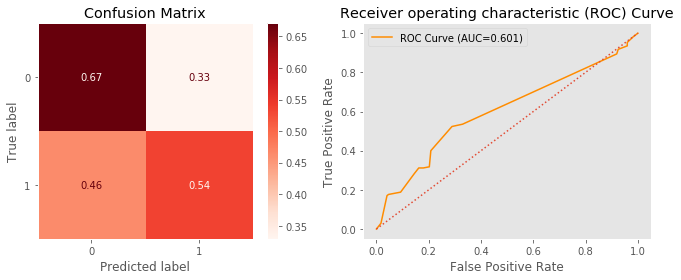

Impressions             0.609536
Spent                   0.088072
age_number              0.067317
Clicks                  0.059949
interest_65             0.045151
interest_10             0.042864
interest_32             0.023156
interest_105            0.017935
interest_22             0.017497
interest_29             0.014413
interest_30             0.014110
interest_21             0.000000
interest_20             0.000000
interest_19             0.000000
interest_18             0.000000
interest_16             0.000000
interest_7              0.000000
interest_15             0.000000
interest_24             0.000000
interest_2              0.000000
gender_M                0.000000
gender_F                0.000000
xyz_campaign_id_1178    0.000000
xyz_campaign_id_936     0.000000
xyz_campaign_id_916     0.000000
fb_counts               0.000000
interest_23             0.000000
interest_114            0.000000
interest_25             0.000000
interest_26             0.000000
interest_1

In [111]:
y_hat_test = tree.predict(X_test)

evaluate_model(y_train, y_test, y_hat_test,X_train, X_test, tree)

First Decision Tree model shows mediocre results. The model scored 73% on the training data and 66% on the testing data. While the scores indicate that the model did not overfit, it only performed slightly better than 50%. It did a descent job predicting true False (79%) however it fell short in predicting true Positive (54%). The most influenctial predictor by far is Total Conversion.

In [112]:
visualize_tree(tree,feature_names=X_train.columns,save_filename='Tree')

[i] Tree saved as Tree.png


# Grid Search CV Model

In [113]:
tree = DecisionTreeClassifier()
# Set up param grid
param_grid = {'criterion':['gini','entropy'],
             'max_depth':[None, 5, 3, 10],
             'max_features':['auto','sqrt',3,5,10,30,70],
              'min_samples_leaf': [1,2,3]}

grid_clf = GridSearchCV(tree,param_grid)# scoring='recall')

In [114]:
timer = Timer()
timer.start()

grid_clf.fit(X_train,y_train)

timer.stop()
grid_clf.best_params_

[i] Timer started at05/06/20 - 05:33 PM
[i] Timer ended at 05/06/20 - 05:33 PM
- Total time = 0:00:04.657207


{'criterion': 'entropy',
 'max_depth': 3,
 'max_features': 'sqrt',
 'min_samples_leaf': 1}

In [115]:
# Create a tree with the gridsearch's best params
best_tree = DecisionTreeClassifier(**grid_clf.best_params_)
best_tree.fit(X_train,y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=3, max_features='sqrt', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

# Grid Search CV Results

Train score= 0.65625
Test score= 0.6559766763848397
              precision    recall  f1-score   support

           0       0.64      0.71      0.68       173
           1       0.67      0.60      0.63       170

    accuracy                           0.66       343
   macro avg       0.66      0.66      0.65       343
weighted avg       0.66      0.66      0.65       343



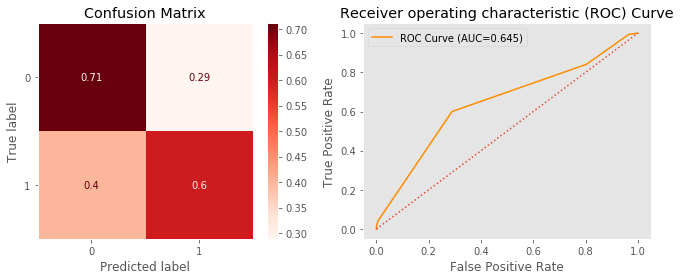

Impressions             0.527427
xyz_campaign_id_936     0.348366
interest_10             0.056473
Clicks                  0.054516
interest_27             0.013218
interest_109            0.000000
interest_24             0.000000
interest_22             0.000000
interest_21             0.000000
interest_20             0.000000
interest_19             0.000000
interest_18             0.000000
interest_16             0.000000
interest_15             0.000000
interest_110            0.000000
interest_7              0.000000
interest_2              0.000000
gender_M                0.000000
gender_F                0.000000
xyz_campaign_id_1178    0.000000
interest_111            0.000000
xyz_campaign_id_916     0.000000
age_number              0.000000
fb_counts               0.000000
Spent                   0.000000
interest_112            0.000000
interest_23             0.000000
interest_25             0.000000
interest_108            0.000000
interest_26             0.000000
interest_1

In [116]:
y_hat_test = best_tree.predict(X_test)

evaluate_model(y_train, y_test,y_hat_test,X_train, X_test, best_tree)

Grid Search CV on a Decision Tree model had very similar results to the plain Decision Tree model. The results were the same with the exception of being a couple of percentage points higher in all categories. The Grid Search model was more efficient; using only 5 predictors and producing better results.

# Random Forest Model

In [123]:
timer = Timer()
timer.start()

grid_clf.best_params_

rf = RandomForestClassifier( )

rf.fit(X_train, y_train)

timer.stop()

[i] Timer started at05/06/20 - 05:40 PM
[i] Timer ended at 05/06/20 - 05:40 PM
- Total time = 0:00:00.302949


# Random Forest Results

Train score= 1.0
Test score= 0.5714285714285714
              precision    recall  f1-score   support

           0       0.58      0.57      0.57       173
           1       0.57      0.58      0.57       170

    accuracy                           0.57       343
   macro avg       0.57      0.57      0.57       343
weighted avg       0.57      0.57      0.57       343



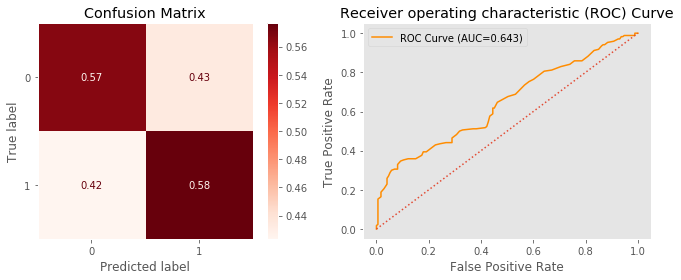

Impressions             0.227738
Spent                   0.171613
Clicks                  0.122597
age_number              0.068390
fb_counts               0.058879
gender_F                0.017996
gender_M                0.017996
interest_27             0.017227
xyz_campaign_id_1178    0.016894
xyz_campaign_id_936     0.015431
interest_10             0.015256
interest_32             0.013686
interest_22             0.013349
interest_64             0.012698
interest_15             0.012253
interest_29             0.012153
interest_16             0.012117
interest_28             0.011933
interest_63             0.010029
interest_18             0.009857
interest_65             0.009813
interest_23             0.009392
interest_20             0.009257
interest_26             0.009175
interest_31             0.008997
interest_21             0.008569
interest_7              0.008258
interest_2              0.007162
interest_25             0.007026
xyz_campaign_id_916     0.006819
interest_3

In [124]:
y_hat_test = rf.predict(X_test)

evaluate_model(y_train, y_test,y_hat_test,X_train, X_test, rf)

# RF Grid Search

In [125]:
tree = RandomForestClassifier()
# Set up param grid
param_grid = {'criterion':['gini','entropy'],
             'max_depth':[None, 5, 3, 10],
             'max_features':['auto','sqrt',3,5,10,30,70],
              'min_samples_leaf': [1,2,3]}

grid_clf = GridSearchCV(tree,param_grid)

timer = Timer()
timer.start()

grid_clf.fit(X_train,y_train)

timer.stop()
grid_clf.best_params_

[i] Timer started at05/06/20 - 05:40 PM
[i] Timer ended at 05/06/20 - 05:43 PM
- Total time = 0:02:42.929305


{'criterion': 'entropy',
 'max_depth': 5,
 'max_features': 10,
 'min_samples_leaf': 2}

In [126]:
# Create a tree with the gridsearch's best params

timer = Timer()
timer.start()

best_tree = RandomForestClassifier(**grid_clf.best_params_)
best_tree.fit(X_train,y_train)

timer.stop()

[i] Timer started at05/06/20 - 05:43 PM
[i] Timer ended at 05/06/20 - 05:43 PM
- Total time = 0:00:00.297051


# RF Grid Search Results

Train score= 0.68625
Test score= 0.6676384839650146
              precision    recall  f1-score   support

           0       0.65      0.75      0.70       173
           1       0.70      0.58      0.63       170

    accuracy                           0.67       343
   macro avg       0.67      0.67      0.66       343
weighted avg       0.67      0.67      0.67       343



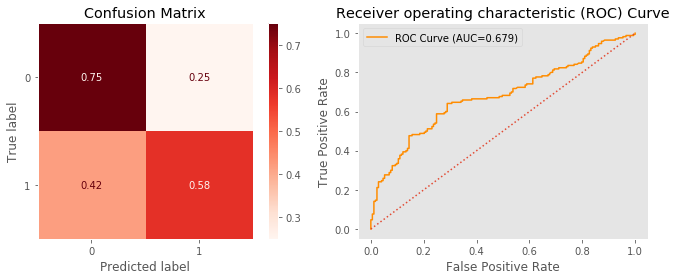

Impressions             0.278756
Spent                   0.211553
Clicks                  0.124889
age_number              0.062198
fb_counts               0.037657
xyz_campaign_id_1178    0.031130
xyz_campaign_id_936     0.025867
interest_23             0.022387
interest_27             0.021239
interest_65             0.018734
gender_F                0.017495
interest_29             0.013512
gender_M                0.012436
interest_22             0.011997
interest_32             0.011360
interest_10             0.010653
interest_20             0.006807
interest_64             0.006107
interest_16             0.005810
interest_28             0.004992
interest_7              0.004576
interest_2              0.004068
interest_30             0.003924
interest_15             0.003907
interest_31             0.003661
interest_26             0.003558
interest_36             0.003549
interest_105            0.003469
interest_18             0.003436
interest_25             0.003285
interest_1

In [127]:
y_hat_test = best_tree.predict(X_test)

evaluate_model(y_train, y_test, y_hat_test,X_train, X_test,best_tree)

# XGBOOST Model

In [135]:
timer = Timer()
timer.start()

xgb_rf = XGBRFClassifier()
xgb_rf.fit(X_train, y_train)

timer.stop() 

[i] Timer started at05/06/20 - 05:49 PM
[i] Timer ended at 05/06/20 - 05:49 PM
- Total time = 0:00:00.148088


# XGBOOST Results

Train score= 0.67875
Test score= 0.6384839650145773
              precision    recall  f1-score   support

           0       0.63      0.70      0.66       173
           1       0.65      0.58      0.61       170

    accuracy                           0.64       343
   macro avg       0.64      0.64      0.64       343
weighted avg       0.64      0.64      0.64       343



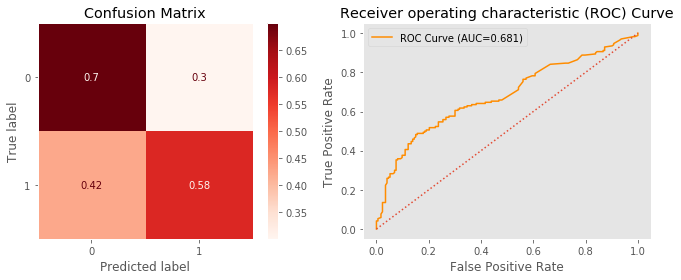

Impressions             0.179873
xyz_campaign_id_1178    0.173972
Spent                   0.106499
Clicks                  0.098449
xyz_campaign_id_936     0.052848
age_number              0.048483
interest_65             0.044111
interest_10             0.040594
interest_27             0.036039
interest_31             0.031171
interest_32             0.029976
interest_23             0.029951
interest_26             0.028617
gender_F                0.028384
fb_counts               0.021440
interest_22             0.018896
interest_2              0.017794
interest_15             0.008353
interest_28             0.004551
interest_7              0.000000
interest_18             0.000000
interest_16             0.000000
interest_107            0.000000
interest_111            0.000000
interest_112            0.000000
interest_20             0.000000
gender_M                0.000000
interest_108            0.000000
interest_109            0.000000
xyz_campaign_id_916     0.000000
interest_1

In [136]:
y_hat_test = xgb_rf.predict(X_test)

evaluate_model(y_train, y_test,y_hat_test,X_train, X_test,xgb_rf)

# XGBOOST RF Model

In [137]:
xgbrf_grid = {'colsample_bynode': 0.8, 'learning_rate': 1,
              'max_depth': 5, 'num_parallel_tree': 100, 
              'objective': 'binary:logistic', 'subsample': 0.8}

timer = Timer()
timer.start()

xrf_clf = XGBRFClassifier(**xgbrf_grid)
xrf_clf.fit(X_train,y_train)

timer.stop()

[i] Timer started at05/06/20 - 05:50 PM
[i] Timer ended at 05/06/20 - 05:50 PM
- Total time = 0:00:00.300487


# XGBOOST RF Results

Train score= 0.7125
Test score= 0.6384839650145773
              precision    recall  f1-score   support

           0       0.63      0.70      0.66       173
           1       0.65      0.58      0.61       170

    accuracy                           0.64       343
   macro avg       0.64      0.64      0.64       343
weighted avg       0.64      0.64      0.64       343



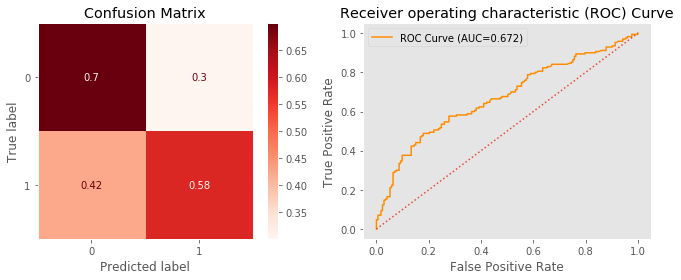

xyz_campaign_id_1178    0.134039
Impressions             0.108605
Spent                   0.057084
interest_65             0.052365
interest_27             0.043213
interest_10             0.041064
age_number              0.040658
Clicks                  0.040490
interest_21             0.036711
interest_23             0.035855
interest_26             0.034565
interest_32             0.033020
interest_22             0.032950
xyz_campaign_id_936     0.030529
interest_29             0.027416
interest_31             0.026478
interest_64             0.025975
interest_63             0.023251
interest_2              0.022172
gender_F                0.018394
interest_28             0.017343
interest_20             0.017337
fb_counts               0.016951
interest_15             0.014071
gender_M                0.013662
xyz_campaign_id_916     0.013080
interest_16             0.012062
interest_18             0.011670
interest_19             0.010825
interest_24             0.008167
interest_1

In [138]:
y_hat_test = xrf_clf.predict(X_test)

evaluate_model(y_train, y_test,y_hat_test,X_train, X_test,xrf_clf)